# LIN Approximation Limitations using DUALEM-482

In [1]:
# Importing libraries
import empymod
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import mu_0
from IPython.display import Image

# Dualem Geometry

In [2]:
Image(url= "Dualem-Geometry.PNG", width=400, height=400)

In [63]:
# Define Dualem-482 geometry

offsets = np.array([2, 4, 8]) # in meters
height = 0 # -0.10 # meters height From ground surface to center of coils
rad = 0.08 # Define radius of coil (8 cm)

# Source and receivers geometry

# For HCP
Hsource = [-rad, rad, -rad, rad, height, height]
Hreceivers = [offsets-rad, offsets+rad,
              np.ones(3)*-rad, np.ones(3)*rad, height, height]

# For VCP
Vsource = [0, 0, height, 90, 0]
Vreceivers = [offsets, offsets*0, height, 90, 0]

# For PRP
Psource = [0, 0, height]
Preceivers = [offsets+0.1, offsets*0, height]

# Frequency
freq = 9000

# Define function to calculate Quadrature using empymod

In [64]:
def Q_HCP(res_ground, height=-0.0):

    Hs_HCP = empymod.dipole(src=[0,0, height], 
                            rec=[offsets, offsets*0, height], 
                            depth = [0], 
                            res = [2e14, res_ground],
                            freqtime = freq,
                            ab = 66,
                            xdirect=None, 
                            verb=0)
    Hp_HCP = empymod.dipole(src=[0,0, height], 
                            rec=[offsets, offsets*0, height],  
                            depth = [], 
                            res = [2e14],
                            freqtime = freq,
                            ab = 66, 
                            verb=0)
    
    return np.abs(np.imag(Hs_HCP/Hp_HCP))

In [65]:
def Q_VCP(res_ground, height=0.0):
    Hs_VCP = empymod.loop(src = [0, 0, height, 90, 0], 
                          rec = [offsets, offsets*0, height, 90, 0], 
                          depth = [0],
                          res = [2e14, res_ground],
                          freqtime = freq,
                          xdirect=None,
                          mrec = 'loop', 
                          verb=1)
    Hp_VCP = empymod.loop(src = [0, 0, height, 90, 0], 
                          rec = [offsets, offsets*0, height, 90, 0],
                          depth=[],
                          res=[2e14], 
                          freqtime=freq, 
                          mrec = 'loop',
                          verb=1)

    return np.abs(np.imag(Hs_VCP/ Hp_VCP))

In [66]:
def Q_PRP(res_ground, height=0.0):
    Hs_PRP = empymod.dipole(src=[0, 0, height], 
                            rec=[offsets+0.1, offsets*0, height], 
                            depth = [0], 
                            res = [2e14, res_ground],
                            freqtime = freq,
                            ab = 64,
                            xdirect = None,
                            verb = 0)
    Hp_PRP = empymod.dipole(src=[0, 0, height], 
                            rec=[offsets+0.1, offsets*0, height], 
                            depth = [], 
                            res = [2e14],
                            freqtime = freq,
                            ab = 66,
                            verb = 0)

    return np.abs(np.imag(Hs_PRP/Hp_PRP))

In [67]:
# Define a homogeneous earth model

depth = [0]

# Define skin factor

sigma = 4/1000 # True conductivity in S/m

print('For a conductivity of: ', sigma*1000, 'mS/m')
print('and a device using a frequency of: ', freq, 'Hz')

delta = np.sqrt(2/(2 * np.pi * freq * mu_0 * sigma))
print('The skin factor is: ', delta)

# Define dimensionless induction number beta

beta = sigma / delta
print('Induction number is: ', beta)

For a conductivity of:  4.0 mS/m
and a device using a frequency of:  9000 Hz
The skin factor is:  83.8820201513134
Induction number is:  4.768602368880084e-05


# Low Induction Number approximation

$(\frac{Hs}{Hp}) \approx \frac{\omega \mu_0 s^2 \sigma}{4}$

### Then we have:

$\sigma_a \approx 4 * Q /(\omega * \mu_0 * s^2)$

- $\sigma_a$   -> Apparent Conductivity
- $\sigma$ -> True conductivity
- $Q$     -> Quadrature
- $\omega$ -> angular frequency
- $\mu_0$ -> magnetic permeability
- $s$     -> coil sepparation

In [68]:
# Function to calculate apparent conductivity according to LIN approximation

def Sigma_app_LIN(Q, freq, mu_0, s):
    sigma_app = 4 * Q / ((2 * np.pi * freq) * mu_0 * s**2)
    return sigma_app

# Example of $\sigma_{app}$ calculation 

In [69]:
Q = Q_HCP(1/sigma)

print('The true conductivity is:', sigma*1000, 'mS/m')
print('Using the HCP configuration')
for s, quad in zip(offsets, Q):
    sigma_app = Sigma_app_LIN(quad, freq, mu_0, s)
    print('For a coil separation: ',s, 'meters, the apparent conductivity is: ', sigma_app*1000, 'mS/m')

The true conductivity is: 4.0 mS/m
Using the HCP configuration
For a coil separation:  2 meters, the apparent conductivity is:  3.898329893852202 mS/m
For a coil separation:  4 meters, the apparent conductivity is:  3.7973670607658767 mS/m
For a coil separation:  8 meters, the apparent conductivity is:  3.586325313711066 mS/m


In [70]:
Q = Q_VCP(1/sigma)

print('The true conductivity is:', sigma*1000, 'mS/m')
print('Using the VCP configuration')
for s, quad in zip(offsets, Q):
    sigma_app = Sigma_app_LIN(quad, freq, mu_0, s)
    print('For a coil separation: ',s, 'meters, the apparent conductivity is: ', sigma_app*1000, 'mS/m')

The true conductivity is: 4.0 mS/m
Using the VCP configuration
For a coil separation:  2 meters, the apparent conductivity is:  3.9491392347206813 mS/m
For a coil separation:  4 meters, the apparent conductivity is:  3.8985962995444523 mS/m
For a coil separation:  8 meters, the apparent conductivity is:  3.8021644579806444 mS/m


In [71]:
Q = Q_PRP(1/sigma)

print('The true conductivity is:', sigma*1000, 'mS/m')
print('Using the VCP configuration')
for s, quad in zip(offsets, Q):
    sigma_app = Sigma_app_LIN(quad, freq, mu_0, s+0.1)
    print('For a coil separation: ',s, 'meters, the apparent conductivity is: ', sigma_app*1000, 'mS/m')

The true conductivity is: 4.0 mS/m
Using the VCP configuration
For a coil separation:  2 meters, the apparent conductivity is:  3.999030415408886 mS/m
For a coil separation:  4 meters, the apparent conductivity is:  3.9962658018322914 mS/m
For a coil separation:  8 meters, the apparent conductivity is:  3.9854580591204907 mS/m


# LIN approximation for different $\sigma$ using the VCP coil

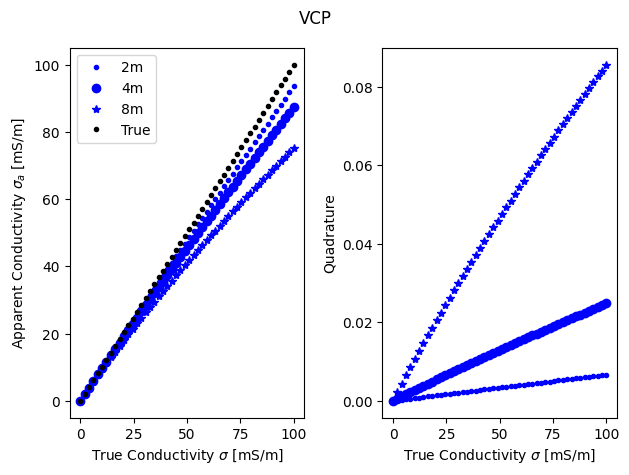

In [72]:
# Define a range of electrical conductivities to test

sigma_arr = np.linspace(0.001/1000, 100/1000) 

# Calculate the quadratures
Q_arr = []
for sigma in sigma_arr:
    Q = Q_VCP(1/sigma)
    Q_arr.append(Q)
    
# Estimate apparent conductivities

sigma_est_2m = []
sigma_est_4m = []
sigma_est_8m = []

Q2_arr = []
Q4_arr = []
Q8_arr = []

for Quad in Q_arr:
    Q2= Quad[0]
    Q2_arr.append(Q2)
    sigma_est_2m.append(Sigma_app_LIN(Q2, freq, mu_0, 2))
    Q4= Quad[1]
    Q4_arr.append(Q4)
    sigma_est_4m.append(Sigma_app_LIN(Q4, freq, mu_0, 4))
    Q8= Quad[2]
    Q8_arr.append(Q8)
    sigma_est_8m.append(Sigma_app_LIN(Q8, freq, mu_0, 8))
    
# Create two subplots and unpack the output array immediately
fig, (ax1, ax2) = plt.subplots(1, 2,)
    
ax1.plot(sigma_arr*1000, np.array(sigma_est_2m)*1000, '.b', label ='2m')
ax1.plot(sigma_arr*1000, np.array(sigma_est_4m)*1000, 'ob', label = '4m')
ax1.plot(sigma_arr*1000, np.array(sigma_est_8m)*1000, '*b', label ='8m')
ax1.plot(sigma_arr*1000, sigma_arr*1000, '.k', label ='True')
ax1.set_xlabel('True Conductivity $\sigma$ [mS/m]')
ax1.set_ylabel('Apparent Conductivity $\sigma_a$ [mS/m]')
ax1.legend()


ax2.plot(sigma_arr*1000, Q2_arr, '.b', label = '2m')
ax2.plot(sigma_arr*1000, Q4_arr, 'ob', label = '4m')
ax2.plot(sigma_arr*1000, Q8_arr, '*b', label = '8m')
ax2.set_xlabel('True Conductivity $\sigma$ [mS/m]')
ax2.set_ylabel('Quadrature')

fig.suptitle('VCP')
fig.tight_layout()

# LIN approximation for different $\sigma$ using the HCP coil

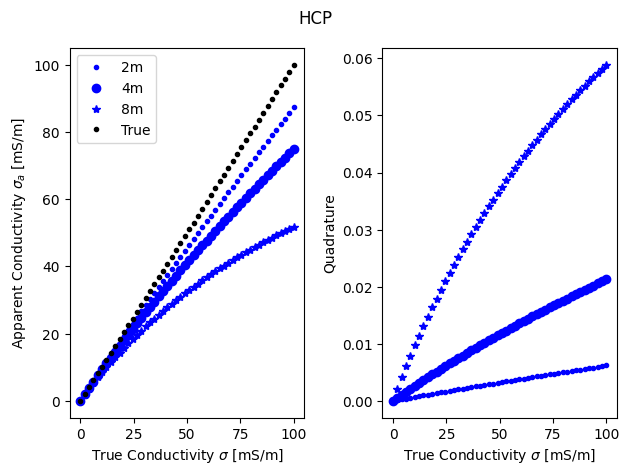

In [73]:
# Define a range of electrical conductivities to test
sigma_arr = np.linspace(0.001/1000, 100/1000) 

# Calculate the quadratures
Q_arr = []
for sigma in sigma_arr:
    Q = Q_HCP(1/sigma)
    Q_arr.append(Q)

# Estimate apparent conductivities
sigma_est_2m = []
sigma_est_4m = []
sigma_est_8m = []

Q2_arr = []
Q4_arr = []
Q8_arr = []

for Quad in Q_arr:
    Q2= Quad[0]
    Q2_arr.append(Q2)
    sigma_est_2m.append(Sigma_app_LIN(Q2, freq, mu_0, 2))
    Q4= Quad[1]
    Q4_arr.append(Q4)
    sigma_est_4m.append(Sigma_app_LIN(Q4, freq, mu_0, 4))
    Q8= Quad[2]
    Q8_arr.append(Q8)
    sigma_est_8m.append(Sigma_app_LIN(Q8, freq, mu_0, 8))
    
# Create two subplots and unpack the output array immediately
fig, (ax1, ax2) = plt.subplots(1, 2,)
    
ax1.plot(sigma_arr*1000, np.array(sigma_est_2m)*1000, '.b', label ='2m')
ax1.plot(sigma_arr*1000, np.array(sigma_est_4m)*1000, 'ob', label = '4m')
ax1.plot(sigma_arr*1000, np.array(sigma_est_8m)*1000, '*b', label ='8m')
ax1.plot(sigma_arr*1000, sigma_arr*1000, '.k', label ='True')
ax1.set_xlabel('True Conductivity $\sigma$ [mS/m]')
ax1.set_ylabel('Apparent Conductivity $\sigma_a$ [mS/m]')
ax1.legend()


ax2.plot(sigma_arr*1000, Q2_arr, '.b', label = '2m')
ax2.plot(sigma_arr*1000, Q4_arr, 'ob', label = '4m')
ax2.plot(sigma_arr*1000, Q8_arr, '*b', label = '8m')
ax2.set_xlabel('True Conductivity $\sigma$ [mS/m]')
ax2.set_ylabel('Quadrature')

fig.suptitle('HCP')
fig.tight_layout()

# LIN approximation for different $\sigma$ using the PRP coil

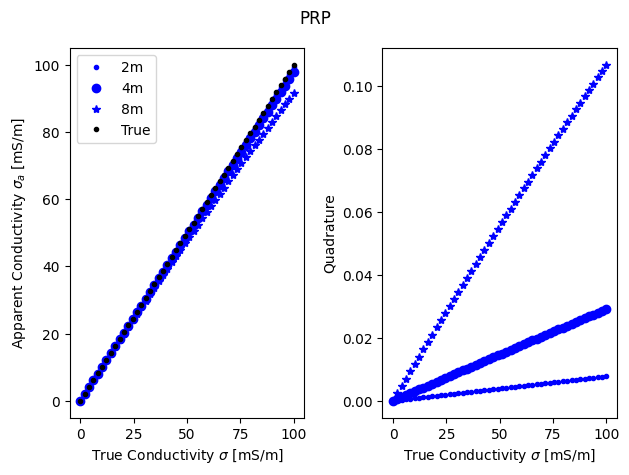

In [74]:
# Define a range of electrical conductivities to test
sigma_arr = np.linspace(0.001/1000, 100/1000) 
Q_arr = []
for sigma in sigma_arr:
    Q = Q_PRP(1/sigma)
    Q_arr.append(Q)

# Calculate the quadratures
sigma_est_2m = []
sigma_est_4m = []
sigma_est_8m = []

Q2_arr = []
Q4_arr = []
Q8_arr = []

for Quad in Q_arr:
    Q2= Quad[0]
    Q2_arr.append(Q2)
    sigma_est_2m.append(Sigma_app_LIN(Q2, freq, mu_0, 2.1))
    Q4= Quad[1]
    Q4_arr.append(Q4)
    sigma_est_4m.append(Sigma_app_LIN(Q4, freq, mu_0, 4.1))
    Q8= Quad[2]
    Q8_arr.append(Q8)
    sigma_est_8m.append(Sigma_app_LIN(Q8, freq, mu_0, 8.1))
    
# Create two subplots and unpack the output array immediately
fig, (ax1, ax2) = plt.subplots(1, 2,)
    
ax1.plot(sigma_arr*1000, np.array(sigma_est_2m)*1000, '.b', label ='2m')
ax1.plot(sigma_arr*1000, np.array(sigma_est_4m)*1000, 'ob', label = '4m')
ax1.plot(sigma_arr*1000, np.array(sigma_est_8m)*1000, '*b', label ='8m')
ax1.plot(sigma_arr*1000, sigma_arr*1000, '.k', label ='True')
ax1.set_xlabel('True Conductivity $\sigma$ [mS/m]')
ax1.set_ylabel('Apparent Conductivity $\sigma_a$ [mS/m]')
ax1.legend()


ax2.plot(sigma_arr*1000, Q2_arr, '.b', label = '2m')
ax2.plot(sigma_arr*1000, Q4_arr, 'ob', label = '4m')
ax2.plot(sigma_arr*1000, Q8_arr, '*b', label = '8m')
ax2.set_xlabel('True Conductivity $\sigma$ [mS/m]')
ax2.set_ylabel('Quadrature')

fig.suptitle('PRP')
fig.tight_layout()

In [75]:
## Calculate apparent sigmas

sigma_arr = np.logspace(-3, -1) 
Q_HCP_list = []
Q_VCP_list = []
Q_PRP_list = []

for sigma in sigma_arr:
    Q_HCP_list.append(Q_HCP(1/sigma))
    Q_VCP_list.append(Q_VCP(1/sigma))
    Q_PRP_list.append(Q_PRP(1/sigma))

sigma_app_HCP = []
sigma_app_VCP = []
sigma_app_PRP = []

for q in range(len(Q_HCP_list)):
    for i in range(len(offsets)):
        sigma_app_HCP.append(Sigma_app_LIN(Q_HCP_list[q][i], freq, mu_0, offsets[i]))
        sigma_app_VCP.append(Sigma_app_LIN(Q_VCP_list[q][i], freq, mu_0, offsets[i]))
        sigma_app_PRP.append(Sigma_app_LIN(Q_PRP_list[q][i], freq, mu_0, offsets[i]+0.1))    

sigma_app_HCP = np.reshape(sigma_app_HCP, np.shape(Q_HCP_list))
sigma_app_VCP = np.reshape(sigma_app_VCP, np.shape(Q_VCP_list))
sigma_app_PRP = np.reshape(sigma_app_PRP, np.shape(Q_PRP_list))
                                                  

In [76]:
## Calculate correction factors

CF_HCP = np.ones_like(sigma_app_HCP)
CF_VCP = np.ones_like(sigma_app_VCP)
CF_PRP = np.ones_like(sigma_app_PRP)

CF_HCP[:,0] = sigma_arr / sigma_app_HCP[:,0]
CF_HCP[:,1] = sigma_arr / sigma_app_HCP[:,1]
CF_HCP[:,2] = sigma_arr / sigma_app_HCP[:,2]

CF_VCP[:,0] = sigma_arr / sigma_app_VCP[:,0]
CF_VCP[:,1] = sigma_arr / sigma_app_VCP[:,1]
CF_VCP[:,2] = sigma_arr / sigma_app_VCP[:,2]

CF_PRP[:,0] = sigma_arr / sigma_app_PRP[:,0]
CF_PRP[:,1] = sigma_arr / sigma_app_PRP[:,1]
CF_PRP[:,2] = sigma_arr / sigma_app_PRP[:,2]

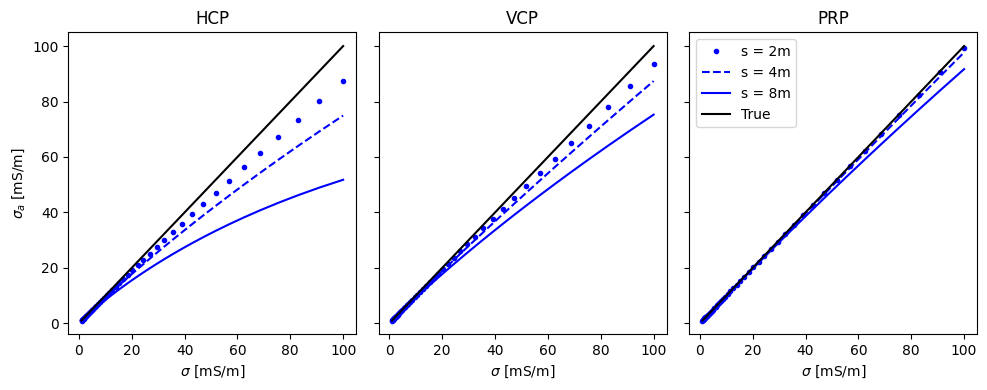

In [77]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(10,4))

ax1.plot(sigma_arr*1000, sigma_app_HCP[:,0]*1000, '.b', label = 'Offset 2m')
ax1.plot(sigma_arr*1000, sigma_app_HCP[:,1]*1000, '--b', label = 'Offset 4m')
ax1.plot(sigma_arr*1000, sigma_app_HCP[:,2]*1000, 'b', label = 'Offset 8m')
ax1.plot(sigma_arr*1000, sigma_arr*1000, 'k', label='True')
ax1.set_ylabel('$\sigma_a$ [mS/m]')
ax1.set_title('HCP')
ax1.set_xlabel('$\sigma$ [mS/m]')

ax2.plot(sigma_arr*1000, sigma_app_VCP[:,0]*1000, '.b', label = 'Offset 2m')
ax2.plot(sigma_arr*1000, sigma_app_VCP[:,1]*1000, '--b', label = 'Offset 4m')
ax2.plot(sigma_arr*1000, sigma_app_VCP[:,2]*1000, 'b', label = 'Offset 8m')
ax2.plot(sigma_arr*1000, sigma_arr*1000, 'k', label='True')
ax2.set_title('VCP')
ax2.set_xlabel('$\sigma$ [mS/m]')

ax3.plot(sigma_arr*1000, sigma_app_PRP[:,0]*1000, '.b', label = 's = 2m')
ax3.plot(sigma_arr*1000, sigma_app_PRP[:,1]*1000, '--b', label = 's = 4m')
ax3.plot(sigma_arr*1000, sigma_app_PRP[:,2]*1000, 'b', label = 's = 8m')
ax3.plot(sigma_arr*1000, sigma_arr*1000, 'k', label='True')
ax3.set_title('PRP')
ax3.set_xlabel('$\sigma$ [mS/m]')
ax3.legend()
#ax3.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.tight_layout()
plt.savefig('LIN_Approx_Sigma_app')

/tmp/ipykernel_1554/2046623737.py:41: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax12.get_shared_y_axes().join(ax12, ax22, ax32)


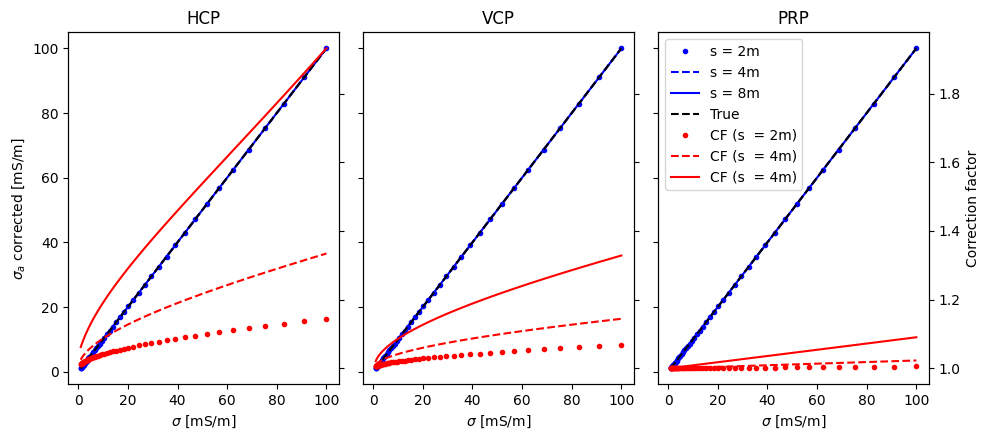

<Figure size 640x480 with 0 Axes>

In [60]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(10,4.5))

sh2,=ax1.plot(sigma_arr*1000, sigma_app_HCP[:,0]*1000 * CF_HCP[:,0], '.b', label = 's = 2m')
sh4,=ax1.plot(sigma_arr*1000, sigma_app_HCP[:,1]*1000 * CF_HCP[:,1], '--b', label = 's = 4m')
sh8,=ax1.plot(sigma_arr*1000, sigma_app_HCP[:,2]*1000 * CF_HCP[:,2], 'b', label = 's = 8m')
sht,=ax1.plot(sigma_arr*1000, sigma_arr*1000, '--k', label='True')
ax1.set_ylabel('$\sigma_a$ corrected [mS/m]')
ax1.set_title('HCP')
ax1.set_xlabel('$\sigma$ [mS/m]')
ax12 = ax1.twinx()
cfh2,= ax12.plot(sigma_arr*1000, CF_HCP[:,0], '.r', label = 'CF (s  = 2m)')
cfh4,=ax12.plot(sigma_arr*1000, CF_HCP[:,1], '--r', label = 'CF (s  = 4m)')
cfh8,=ax12.plot(sigma_arr*1000, CF_HCP[:,2], 'r', label = 'CF (s  = 4m)')


ax2.plot(sigma_arr*1000, sigma_app_VCP[:,0]*1000 * CF_VCP[:,0], '.b', label = 's = 2m')
ax2.plot(sigma_arr*1000, sigma_app_VCP[:,1]*1000 * CF_VCP[:,1], '--b', label = 's = 4m')
ax2.plot(sigma_arr*1000, sigma_app_VCP[:,2]*1000 * CF_VCP[:,2], 'b', label = 's = 8m')
ax2.plot(sigma_arr*1000, sigma_arr*1000, '--k', label='True')
ax2.set_title('VCP')
ax2.set_xlabel('$\sigma$ [mS/m]')
ax22 = ax2.twinx()
ax22.plot(sigma_arr*1000, CF_VCP[:,0], '.r', label = 'CF VCP (s  = 2m)')
ax22.plot(sigma_arr*1000, CF_VCP[:,1], '--r', label = 'CF VCP (s  = 4m)')
ax22.plot(sigma_arr*1000, CF_VCP[:,2], 'r', label = 'CF VCP (s  = 8m)')

s2 = ax3.plot(sigma_arr*1000, sigma_app_PRP[:,0]*1000 * CF_PRP[:,0], '.b', label = 's = 2m')
s4 = ax3.plot(sigma_arr*1000, sigma_app_PRP[:,1]*1000 * CF_PRP[:,1], '--b', label = 's = 4m')
s8 = ax3.plot(sigma_arr*1000, sigma_app_PRP[:,2]*1000 * CF_PRP[:,2], 'b', label = 's = 8m')
st = ax3.plot(sigma_arr*1000, sigma_arr*1000, '--k', label='True')
ax3.set_xlabel('$\sigma$ [mS/m]')
ax3.set_title('PRP')

ax32 = ax3.twinx()
cf2 = ax32.plot(sigma_arr*1000, CF_PRP[:,0], '.r', label = 'CF (s  = 2m)')
cf4 = ax32.plot(sigma_arr*1000, CF_PRP[:,1], '--r', label = 'CF (s  = 4m)')
cf8 = ax32.plot(sigma_arr*1000, CF_PRP[:,2], 'r', label = 'CF (s  = 8m)')
ax32.set_ylabel('Correction factor')
ax3.legend(handles = [sh2, sh4, sh8, sht, cfh2, cfh4, cfh8],  loc='upper left')

ax12.get_shared_y_axes().join(ax12, ax22, ax32)

ax12.tick_params(labelright=False)
ax22.tick_params(labelright=False)
plt.tight_layout()
plt.show()
plt.savefig('LIN_Approx_CF')

In [61]:
## Calculate sigma apparent for increasing air height

sigma_halfspace = 1/1000

air_height_arr = -np.linspace(0, 1, 20)

Q_HCP_list = []
Q_VCP_list = []
Q_PRP_list = []

for height in air_height_arr:
    Q_HCP_list.append(Q_HCP(1/sigma_halfspace, height))
    Q_VCP_list.append(Q_VCP(1/sigma_halfspace, height))
    Q_PRP_list.append(Q_PRP(1/sigma_halfspace, height))
    
sigma_app_HCP = []
sigma_app_VCP = []
sigma_app_PRP = []

for q in range(len(Q_HCP_list)):
    for i in range(len(offsets)):
        sigma_app_HCP.append(Sigma_app_LIN(Q_HCP_list[q][i], freq, mu_0, offsets[i]))
        sigma_app_VCP.append(Sigma_app_LIN(Q_VCP_list[q][i], freq, mu_0, offsets[i]))
        sigma_app_PRP.append(Sigma_app_LIN(Q_PRP_list[q][i], freq, mu_0, offsets[i]+0.1))    

sigma_app_HCP = np.reshape(sigma_app_HCP, np.shape(Q_HCP_list))
sigma_app_VCP = np.reshape(sigma_app_VCP, np.shape(Q_VCP_list))
sigma_app_PRP = np.reshape(sigma_app_PRP, np.shape(Q_PRP_list))

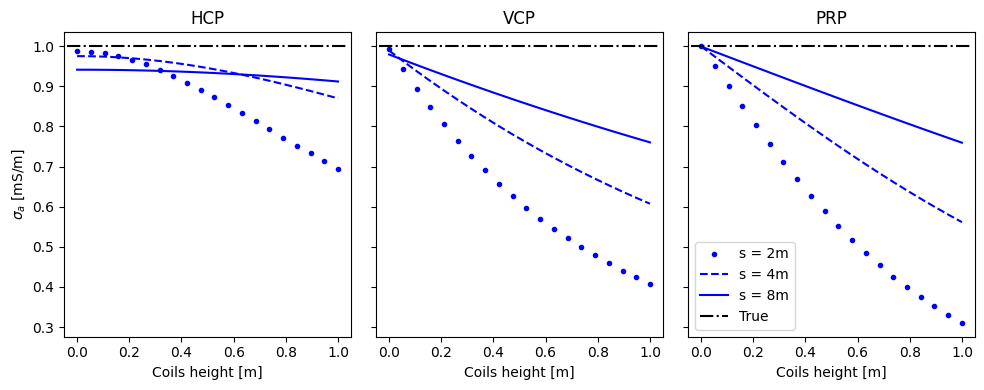

In [62]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(10,4))

ax1.plot(-air_height_arr, sigma_app_HCP[:,0]*1000, '.b', label = 'Offset 2m')
ax1.plot(-air_height_arr, sigma_app_HCP[:,1]*1000, '--b', label = 'Offset 4m')
ax1.plot(-air_height_arr, sigma_app_HCP[:,2]*1000, 'b', label = 'Offset 8m')
ax1.axhline(y=sigma_halfspace*1000, xmin=0.01, xmax=0.99, c='k', ls='-.', label='True')
#ax1.plot(sigma_halfspace, sigma_arr*1000, 'k', label='True')
ax1.set_ylabel('$\sigma_a$ [mS/m]')
ax1.set_title('HCP')
ax1.set_xlabel('Coils height [m]')

ax2.plot(-air_height_arr, sigma_app_VCP[:,0]*1000, '.b', label = 'Offset 2m')
ax2.plot(-air_height_arr, sigma_app_VCP[:,1]*1000, '--b', label = 'Offset 4m')
ax2.plot(-air_height_arr, sigma_app_VCP[:,2]*1000, 'b', label = 'Offset 8m')
ax2.axhline(y=sigma_halfspace*1000,xmin=0.01, xmax=0.99, c='k', ls='-.', label='True')
#ax2.plot(sigma_arr*1000, sigma_arr*1000, 'k', label='True')
ax2.set_title('VCP')
ax2.set_xlabel('Coils height [m]')

ax3.plot(-air_height_arr, sigma_app_PRP[:,0]*1000, '.b', label = 's = 2m')
ax3.plot(-air_height_arr, sigma_app_PRP[:,1]*1000, '--b', label = 's = 4m')
ax3.plot(-air_height_arr, sigma_app_PRP[:,2]*1000, 'b', label = 's = 8m')
ax3.axhline(y=sigma_halfspace*1000, xmin=0.01, xmax=0.99, c='k', ls='-.', label='True')
#ax3.plot(sigma_arr*1000, sigma_arr*1000, 'k', label='True')
ax3.set_title('PRP')
ax3.set_xlabel('Coils height [m]')
ax3.legend()
#ax3.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.tight_layout()
plt.savefig('LIN_Approx_height')